In [2]:
import sys

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
import pytorch_lightning as pl

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms

import sys
sys.path.append('../')

from cc import cc
from models.vae import train_vanilla_vae, train_beta_vae, train_factor_vae
from tools.manifold_generator import Manifold

from torchvision.datasets import MNIST
from torchvision import transforms

pl.seed_everything(1)

Global seed set to 1


1

In [40]:
# set default tensor type to cuda float
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [35]:
transform = transforms.Compose([
	# you can add other transformations in this list
	transforms.ToTensor(),
    # add transform to pad the image to 32x32
	transforms.Pad((2,2,2,2), fill=0, padding_mode='constant')
])

dataset = MNIST(root='./torch-dataset', train=True,
						download=True,  transform=transform)

# load dataset into pytorch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=600000)
data,labels = next(iter(data_loader))
data = data.cuda()
data = data[labels==5]
data = data[:,0,:,:]

H = 32
W = 32
D = H * W

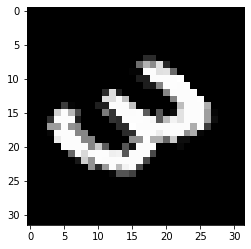

In [24]:
# print an example image from data
plt.imshow(data[0].cpu().numpy(), cmap='gray')

image = data[0]
# translate the image right by a pixel
image_right = torch.roll(image, shifts=1, dims=1)
# translate the image left by a pixel
image_left = torch.roll(image, shifts=-1, dims=1)
# translate the image up by a pixel
image_up = torch.roll(image, shifts=1, dims=0)
# translate the image down by a pixel
image_down = torch.roll(image, shifts=-1, dims=0)
# rotate the image 45 degrees clockwise using transforms.functional.rotate
# add one dimension at front of iamge
image_rotated = transforms.functional.rotate(image.unsqueeze(0), angle=-45)[0,:,:]
# show rotated image
plt.imshow(image_rotated.cpu().numpy(), cmap='gray')

In [2]:
# Data parameters
H = 25
W = 25
D = H * W
hb = 15
wb = 15

# Data preprocessing parameter
reduced_dim = 100

# Image plotting parameter
num_images = 5

In [37]:
reduced_dim=100

In [28]:
# Data generation
def generate_data():
    X = []
    for i in range(H - hb):
        for j in range(W - wb):
            sample = torch.zeros((H, W))
            for k in range(i, i + hb):
                for l in range(j, j + wb):
                    sample[k][l] = 1.0
            X.append(sample)
    X = torch.stack(X)
    return X

In [52]:
# generate a dataset using a sample image from mnist, and a combination of y-translations and rotations between -180 and 180 degrees
num_y_translations = 20
angle_range = 45
# how many degrees between each rotation instance
angle_space = 3
def generate_data_from_mnist(image):
	X = []
	for i in range(-num_y_translations//2, num_y_translations//2):
		for j in range(-angle_range, angle_range, angle_space):
			sample = transforms.functional.rotate(image.unsqueeze(0), angle=j)[0,:,:]
			sample = torch.roll(sample, shifts=i, dims=0)
			X.append(sample)

	X = torch.stack(X)
	return X

In [45]:
# Convert data to Fourier basis
# band_limit is the max frequency along each axis to keep
def fft(X, band_limit=None):
    X_f = torch.fft.fft2(X)
    if band_limit is not None:
        X_f = X_f[:, :band_limit, :band_limit]

        X_f_real_flat = X_f.real.reshape(X_f.shape[0], band_limit*band_limit)
        X_f_imag_flat = X_f.imag.reshape(X_f.shape[0], band_limit*band_limit)
    else:
        X_f_real_flat = X_f.real.reshape(X_f.shape[0], D)
        X_f_imag_flat = X_f.imag.reshape(X_f.shape[0], D)
    Z = torch.cat([X_f_real_flat, X_f_imag_flat], dim=1)
    
    return Z

# Convert data from Fourier basis
# original_size is the original length of each axis of the data
def ifft(Z, original_size=None):
    if original_size is not None:
        band_limit = int(np.sqrt(Z.shape[1] / 2))
        X_f_real_flat_obs = Z[:, :band_limit**2].reshape(Z.shape[0], band_limit, band_limit)
        X_f_imag_flat_obs = Z[:, band_limit**2:].reshape(Z.shape[0], band_limit, band_limit)

        X_f_real_flat = torch.zeros((Z.shape[0], original_size, original_size))
        X_f_imag_flat = torch.zeros((Z.shape[0], original_size, original_size))
        X_f_real_flat[:, :band_limit, :band_limit] = X_f_real_flat_obs
        X_f_imag_flat[:, :band_limit, :band_limit] = X_f_imag_flat_obs

    else:
        X_f_real_flat = Z[:, :D].reshape(Z.shape[0], H, W)
        X_f_imag_flat = Z[:, D:].reshape(Z.shape[0], H, W)
    
    X_f = torch.complex(X_f_real_flat, X_f_imag_flat)
    
    X = torch.fft.ifft2(X_f).real
    
    return X

In [46]:
# Center and project data to lower dimensional space for easier data processing
def pca(Z, Z_mean=None, V=None):
    if Z_mean is None:
        Z_mean = Z.mean(dim=0, keepdim=True)
    if V is None:
        U, S, Vt = torch.linalg.svd(Z - Z_mean, full_matrices=False)
        V = Vt.T[:,:reduced_dim]    
    Z_c = (Z - Z_mean)@V
    return Z_c, Z_mean, V

# Project lower dimensional data back to higher-dimensional space
def ipca(Z_c, Z_mean, V):
    return Z_c @ V.T + Z_mean

In [53]:
band_limit = 15
X = generate_data_from_mnist(image = data[0])
# center and normalize the dataset
X_mean = X.mean(dim=0, keepdim=True)
X_std = (X - X_mean).pow(2).mean().sqrt()
X = (X - X_mean) / X_std

# FX = fft(X, band_limit=band_limit)
FX = fft(X)
FX_c, FX_mean, V = pca(FX)

# center and normalize the data
FX_c_mean = FX_c.mean(dim=0, keepdim=True)
FX_c_std = (FX_c - FX_c_mean).pow(2).mean().sqrt()
FX_c = (FX_c - FX_c_mean) / FX_c_std
# FX_c = FX

In [55]:
f, g = cc(FX_c, n_iter=500, n_iter_inner = 3000, r_min_coeff=0.15, r_dimcheck_coeff=0.15, thres_recon=1e-4, n_iter_rsearch=2, alpha_max=0.4)

 13%|█▎        | 65/500 [17:56<2:00:04, 16.56s/iters, local_recon=4.58e-5, d=1, r_ratio=0.173, alpha=0.4] 


KeyboardInterrupt: 

In [26]:
Z = f(FX_c)
u, s, vt = torch.linalg.svd(Z - Z.mean(axis=0, keepdims=True), full_matrices=False)
print(s)


tensor([1.6738e+01, 1.2605e+01, 5.4313e+00, 2.5806e+00, 9.4264e-01, 3.6864e-01,
        1.7368e-01, 9.9761e-02, 6.9733e-02, 6.7527e-02, 2.0060e-02, 3.9212e-03,
        3.1404e-04, 8.5711e-05, 2.2832e-06, 1.1086e-06, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07, 8.7934e-07,
        8.7934e-07, 8.7934e-07, 8.7934e-

In [17]:
Z = f(FX_c)
FXhat_c = g(Z)
# first unnormalize
FXhat_c = FXhat_c * FX_c_std + FX_c_mean
# then invert pca
FXhat = ipca(FXhat_c, FX_mean, V)
# finally invert fft
# Xhat = ifft(FXhat, original_size=H)
Xhat = ifft(FXhat)

In [23]:
FXhat_pca = FX_c.clone()
FXhat_pca = ipca(FXhat_pca, FX_mean, V)
Xhat_pca = ifft(FXhat_pca)

In [60]:
((torch.linalg.norm(X - Xhat) ** 2) / (X.shape[0] * H * W)) ** 0.5

tensor(0.6759)

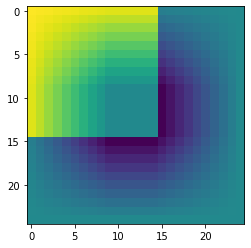

In [18]:
plt.imshow(X[0])

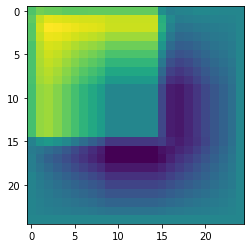

In [19]:
plt.imshow(Xhat[0])

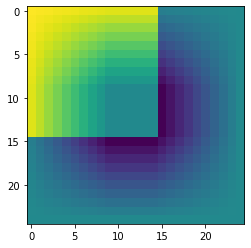

In [24]:
plt.imshow(Xhat_pca[0])

In [15]:
def display_images_in_grid(imgs):
    M = imgs.shape[0]
    N = imgs.shape[1]
    fig, ax = plt.subplots(M, N)
    for m in range(M):
        for n in range(N):
            ax[m, n].set_axis_off()
            ax[m, n].imshow(imgs[m, n])
    fig.set_size_inches(10, 2.25)
    fig.tight_layout()

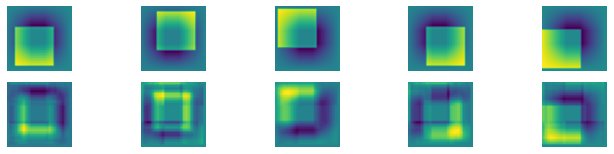

In [16]:
# Regenerations
r = torch.randint(low=0, high=X.shape[0], size=(num_images,))
imgs = torch.stack([X[r], Xhat[r]])
display_images_in_grid(imgs)

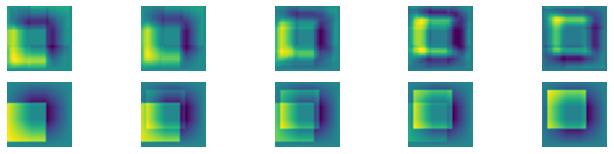

In [35]:
# Interpolations
r = torch.randint(low=0, high=X.shape[0], size=(2,))
base_X1 = X[r[0]]
base_X2 = X[r[1]]
base_Z1 = Z[r[0]]
base_Z2 = Z[r[1]]
semantic_interpolations = []
visual_interpolations = []
for k in range(num_images):
    theta = k / (num_images - 1)
    
    sem = theta * base_Z1 + (1 - theta) * base_Z2
    semantic_interpolations.append(sem)
    
    vis = theta * base_X1 + (1 - theta) * base_X2
    visual_interpolations.append(vis)
    
semantic_interpolations = torch.stack(semantic_interpolations)
semantic_interpolations = g(semantic_interpolations)
semantic_interpolations = ipca(semantic_interpolations, FX_mean, V)
semantic_interpolations = ifft(semantic_interpolations, original_size=H)

visual_interpolations = torch.stack(visual_interpolations)

interpolations = torch.stack((semantic_interpolations, visual_interpolations))
display_images_in_grid(interpolations)

In [15]:
torch.linalg.norm(interpolations[0] - interpolations[1])

tensor(8.9758)

In [25]:
Z.shape

torch.Size([100, 100])

In [27]:
Z = f(FX_c)
u, s, vt = torch.linalg.svd(Z - Z.mean(axis=0, keepdims=True), full_matrices=False)
Z_coord = Z @ vt.T[:,:2]
print(Z_coord.shape)

torch.Size([100, 2])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

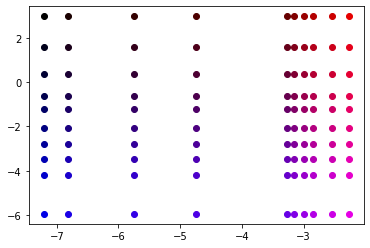

In [29]:
for i in range(H - hb):
	for j in range(W - wb):
		plt.scatter(Z_coord[i, 0], Z_coord[j, 1], c=(i/(H - hb),0,j/(W-wb)))

plt.show()

In [36]:
# flatten X into vectors
X_flat = X.reshape(X.shape[0], -1)
# pca coordinates of top 2 principal components
u, s, vt = torch.linalg.svd(X_flat - X_flat.mean(axis=0, keepdims=True), full_matrices=False)
X_coord = X_flat @ vt.T[:,:2]

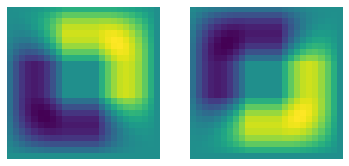

In [41]:
to_show = vt.T[:,:2].T
# expand to_show back into images
to_show = to_show.reshape(2, H, W)
# scale components of each image to [0, 1]
for i in range(2):
	to_show[i] = (to_show[i] - to_show[i].min()) / (to_show[i].max() - to_show[i].min())
# display images
f, ax = plt.subplots(1, 2)
for i in range(2):
	ax[i].imshow(to_show[i])
	ax[i].set_axis_off()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

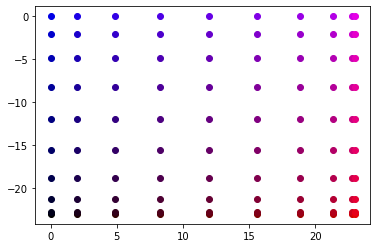

In [33]:
for i in range(H - hb):
	for j in range(W - wb):
		plt.scatter(X_coord[i, 0], X_coord[j, 1], c=(i/(H - hb),0,j/(W-wb)))

plt.show()